https://radimrehurek.com/data_science_python/

#### Import modules

In [84]:
from textblob.classifiers import NaiveBayesClassifier
from textblob import TextBlob
import random
import time
import os
import sys
import os.path
import string

# ---- for TF-IDF & NLTK
import math
from textblob import TextBlob as tb
import nltk
from nltk.corpus import wordnet as wn
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from pathlib import Path
from beautifultable import BeautifulTable

import re, string, unicodedata
import contractions
import inflect
from bs4 import BeautifulSoup
from tabulate import tabulate

allRunsAccuracy = []

import matplotlib.pyplot as plt
import csv
from textblob import TextBlob
import pandas
import sklearn
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.learning_curve import learning_curve

#### The rest

In [115]:
prefix = r"C:\Users\ani"
sentences = pandas.read_csv(prefix + r'\Dropbox\Stuff\university\data\allMergedNoNL.csv', sep='|', quoting=csv.QUOTE_NONE,
                           names=["Label", "Sentence"], encoding = "ISO-8859-1")
print(sentences[:10]) 

  Label                                           Sentence
0    CD  provided some conditions are satisfied,the ext...
1    CD  but how am i supposed to find those maximum an...
2    CD  we've actually alreaOMITTED done this in some ...
3    CD                       here's a frour-step process 
4    AP  first,differentiate your function can find all...
5    CD  those are places where the derivative is equal...
6    CD  and also lists the end points if they're inclu...
7    CD                          check those points,right 
8    AP  check the end points,check the critical points...
9    EX                             let's work an example 


In [116]:
sentences.groupby('Label').describe()

Sentence                                                               
         count unique                                                top freq
Label                                                                        
AP         317    317  and again,here i'm going to,here i'm asking yo...    1
CD        6652   6639                                            rumble     2
CM         277    277          and this function is called the residual     1
EX         562    561                         so let me show you a demo     2
SM         570    570  in the next video,we will have an overview of ...    1

  Label                                           Sentence  length
0    CD  provided some conditions are satisfied,the ext...     119
1    CD  but how am i supposed to find those maximum an...      63
2    CD  we've actually alreaOMITTED done this in some ...     131
3    CD                       here's a frour-step process       28
4    AP  first,differentiate your function can find all...      67


["and i'm labeling these points OMITTED sub i,so my left hand OMITTED point is OMITTED sub and my right hand OMITTED point is OMITTED sub n,and my cut points in between where i'm cutting up to partition are i over n. so,the first one here,or the one after the of anyway,is over n. the next one is over n,the next one is over n,and each of those subintervals has the same width,over n. now,i also have to choose points to sample the function at,and i'm just going to choose the right hand end point here ", "some epsilon bigger than zero,a corresponding value of delta is going to be epsilon over 

Text(0,0.5,'Quantity')

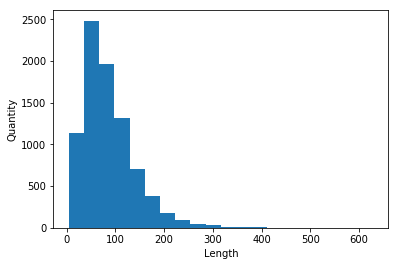

In [87]:
sentences['length'] = sentences['Sentence'].map(lambda text: len(text))
print(sentences.head())

sentences.length.plot(bins=20, kind='hist')

print("\n")
sentences.length.describe()
print(list(sentences.Sentence[sentences.length > 500]))

#sentences.hist(column='length', by='Label', bins='auto',figsize=(10, 15), color="c")
plt.xlabel('Length')
plt.ylabel('Quantity')

In [117]:
#split a sent into its individual words
def split_into_tokens(sent):
    #sent = unicode(sent, 'utf8')  # convert bytes into proper unicode
    return TextBlob(sent).words

sentences.Sentence.apply(split_into_tokens)

0       [provided, some, conditions, are, satisfied, t...
1       [but, how, am, i, supposed, to, find, those, m...
2       [we, 've, actually, alreaOMITTED, done, this, ...
3                      [here, 's, a, frour-step, process]
4       [first, differentiate, your, function, can, fi...
5       [those, are, places, where, the, derivative, i...
6       [and, also, lists, the, end, points, if, they,...
7                           [check, those, points, right]
8       [check, the, end, points, check, the, critical...
9                            [let, 's, work, an, example]
10                     [okay, let, 's, work, an, example]
11      [let, 's, look, at, the, function, given, by, ...
12      [but, let, 's, only, consider, this, function,...
13      [let, 's, consider, a, maximum, minimum, value...
14                           [and, now, i, differentiate]
15      [yeah, the, first, step, is, to, differentiate...
16      [so, before, i, differentiate, it, i, 'm, just...
17      [inste

In [146]:
# pre-processing
def split_into_lemmas(sent):
    words = TextBlob(sent).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

sentences.Sentence.head().apply(split_into_lemmas)

0    [provided, some, condition, are, satisfied, th...
1    [but, how, am, i, supposed, to, find, those, m...
2    [we, 've, actually, alreaOMITTED, done, this, ...
3                   [here, 's, a, frour-step, process]
4    [first, differentiate, your, function, can, fi...
Name: Sentence, dtype: object

In [90]:
# Data to vectors

# convert each message, represented as a list of tokens (lemmas) above, 
# into a vector that machine learning models can understand

bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(sentences['Sentence'])
print(len(bow_transformer.vocabulary_))

5657


In [156]:
message1000 = sentences['Sentence'][999]
print(message1000)

bow1000 = bow_transformer.transform([message1000])
print(bow1000)
print(bow1000.shape)
print("OMITTED appears 3 times, i appears twice etc")

featureList = bow_transformer.get_feature_names()
finalFeatureList = []

def removeNumsFromFeatureList(featureList):
    isNum = re.compile("[0-9]")
    hasApostrophe = re.compile("'\w+")
        
    for feat in featureList:
        if isNum.match(feat): pass
        elif hasApostrophe.match(feat): pass
        elif "OMITTED" in feat.upper(): pass
        elif "NUMBER" in feat.upper(): pass
        elif ("-" or "+") in feat.upper(): pass
        else: finalFeatureList.append(feat)

print(len(featureList))
removeNumsFromFeatureList(featureList)
print(len(finalFeatureList))

#print(bow_transformer.get_feature_names()[5214])

all right,now we've got ta figure out,when is the derivative equal to zero,so i'm trying to solve this 
  (0, 5)	1
  (0, 8)	1
  (0, 191)	1
  (0, 1339)	1
  (0, 1734)	1
  (0, 1929)	1
  (0, 2175)	1
  (0, 2413)	1
  (0, 2695)	1
  (0, 3373)	1
  (0, 3518)	1
  (0, 4301)	1
  (0, 4650)	1
  (0, 4663)	1
  (0, 4967)	1
  (0, 5048)	1
  (0, 5084)	1
  (0, 5128)	2
  (0, 5233)	1
  (0, 5478)	1
  (0, 5514)	1
  (0, 5650)	1
(1, 5657)
OMITTED appears 3 times, i appears twice etc
5657
5421


In [157]:
sentences_bow = bow_transformer.transform(sentences['Sentence'])
print('sparse matrix shape:', sentences_bow.shape)
print('number of non-zeros:', sentences_bow.nnz)
print('sparsity: %.2f%%' % (100.0 * sentences_bow.nnz / (sentences_bow.shape[0] * sentences_bow.shape[1])))

#after the counting, the term weighting and normalization can be done with TF-IDF, using scikit-learn's TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(sentences_bow)
tfidf1000 = tfidf_transformer.transform(bow1000)
#print(tfidf1451)

# To transform the entire bag-of-words corpus into TF-IDF corpus at once:
sentences_tfidf = tfidf_transformer.transform(sentences_bow)
print(sentences_tfidf.shape)

sparse matrix shape: (8380, 5657)
number of non-zeros: 117146
sparsity: 0.25%
(8380, 5657)


#### RUN THE CLASSIFIER!
# TIME CONSUMING!

In [154]:
# Using Multinomial Naive Bayes classifier
%time label_classifier = MultinomialNB().fit(sentences_tfidf, sentences['Label'].fillna(""))

Wall time: 172 ms


In [163]:
print('Predicted:', label_classifier.predict(tfidf1000)[0])
print('Actual:', sentences.Label[999])

Predicted: CD
Actual: CD


In [187]:
all_predictions = label_classifier.predict(sentences_tfidf)
#print(all_predictions)

print('Accuracy:\t', accuracy_score(sentences['Label'].fillna(""), all_predictions))
print('\n========Confusion matrix=========\n', confusion_matrix(sentences['Label'].fillna(""), all_predictions))
print('(row=Actual, col=Predicted)')

print("\n_______________Multinomial Naive Bayes______________")
print(classification_report(sentences['Label'].fillna(""), all_predictions))

Accuracy:	 0.7960620525059666

========Confusion matrix=========
 [[   0    0    2    0    0    0]
 [   0    3  314    0    0    0]
 [   0    0 6652    0    0    0]
 [   0    0  277    0    0    0]
 [   0    0  555    0    7    0]
 [   0    0  561    0    0    9]]
(row=Actual, col=Predicted)

_______________Multinomial Naive Bayes______________
             precision    recall  f1-score   support

                  0.00      0.00      0.00         2
         AP       1.00      0.01      0.02       317
         CD       0.80      1.00      0.89      6652
         CM       0.00      0.00      0.00       277
         EX       1.00      0.01      0.02       562
         SM       1.00      0.02      0.03       570

avg / total       0.80      0.80      0.71      8380



C:\Users\ani\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
